# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных:

Данные геологоразведки трёх регионов находятся в файлах: 
- /datasets/geo_data_0.csv;
- /datasets/geo_data_1.csv;
- /datasets/geo_data_2.csv.

Признаки:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

Условия задачи:

Для обучения модели будем рассматривать модель линейной регрессии (остальные — недостаточно предсказуемые).
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Для решения поставленной задачи будем придерживаться следующей инструкции:

Загрузим и подготовим данные.

Обучим и проверим модель для каждого региона:
 - 2.1. Разобъем данные на обучающую и валидационную выборки в соотношении 75:25.
 - 2.2. Обучим модель и сделаем предсказания на валидационной выборке.
 - 2.3. Сохраним предсказания и правильные ответы на валидационной выборке.
 - 2.4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.
 - 2.5. Проанализируем результаты.
 
Подготовим к расчёту прибыли:
 - 3.1. Все ключевые значения для расчётов сохраним в отдельных переменных.
 - 3.2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе. 
 - 3.3. Напишем выводы по этапу подготовки расчёта прибыли.

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
 - 4.1. Выберем скважины с максимальными значениями предсказаний. 
 - 4.2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
 - 4.3. Рассчитаем прибыль для полученного объёма сырья.

Посчитаем риски и прибыль для каждого региона:
 - 5.1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
 - 5.2. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
 - 5.3. Напишем выводы: предложите регион для разработки скважин и обоснуйте выбор.

## Загрузка и подготовка данных

In [1]:
#импортируем библиотеки необходимые для работы
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [2]:
#откроем/ прочтем все имеющиеся данные
data_0 = pd.read_csv('/datasets/geo_data_0.csv')  #первый регион
data_1 = pd.read_csv('/datasets/geo_data_1.csv')  #второй регион
data_2 = pd.read_csv('/datasets/geo_data_2.csv')  #третий регион

In [3]:
#по каждому датасету/региону выведем несколько строчек для ознакомления с представленными данными
display(data_0.head(15))
display(data_1.head(15))
display(data_2.head(15))

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


In [4]:
#посмотрим общую информацию по каждому датасету
print('Размерность датасета 1:', data_0.shape)
data_0.info()
print('-------------------------------------------')
print('Размерность датасета 2:', data_1.shape)
data_1.info()
print('-------------------------------------------')
print('Размерность датасета 3:', data_2.shape)
data_2.info()

Размерность датасета 1: (100000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
-------------------------------------------
Размерность датасета 2: (100000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
----------------

In [5]:
#убедимся в отсутствии пропусков в каждом датасете
display('Пропущено данных в первом датасете:', data_0.isna().sum())
display('Пропущено данных во втором датасете:', data_1.isna().sum())
display('Пропущено данных в третьем датасете:', data_2.isna().sum())

'Пропущено данных в первом датасете:'

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

'Пропущено данных во втором датасете:'

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

'Пропущено данных в третьем датасете:'

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [6]:
#убедимся в оствуствии дублирующих строк
print('Количество дублирующих строк в первом датасете:', data_0.duplicated().sum())
print('Количество дублирующих строк во втором датасете:', data_1.duplicated().sum())
print('Количество дублирующих строк в третьем датасете:', data_2.duplicated().sum())

Количество дублирующих строк в первом датасете: 0
Количество дублирующих строк во втором датасете: 0
Количество дублирующих строк в третьем датасете: 0


In [7]:
#посмотрим показатели данных по всем датасетам
display(data_0.describe())
display(data_1.describe())
display(data_2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Из описания представленных данных:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

Уникальный идентификатор для решения данной задачи нам не нужен. Такие параметры как f0, f1 и f2 указаны как непонятные для чего, но очень важны. А объемы запасов в определенной скважине понятный и оцениваемый параметр, рассмотрим данные столбца product. Так как данные представлены в размерности тыс. баррелей, то округлим значения до целых.

In [8]:
#удалим столбец id в каждой выборке
data_0 = data_0.drop(columns=['id'])
data_1 = data_1.drop(columns=['id'])
data_2 = data_2.drop(columns=['id'])

#привеедем тип данных столбца product к целочисленным значениям
data_0['product'] = data_0['product'].astype('int64')
data_1['product'] = data_1['product'].astype('int64')
data_2['product'] = data_2['product'].astype('int64')

In [9]:
#убедимся в проделанной операции
print('Размерность датасета 1:', data_0.info())
print('Размерность датасета 2:', data_1.info())
print('Размерность датасета 3:', data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 3.1 MB
Размерность датасета 1: None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 3.1 MB
Размерность датасета 2: None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ---

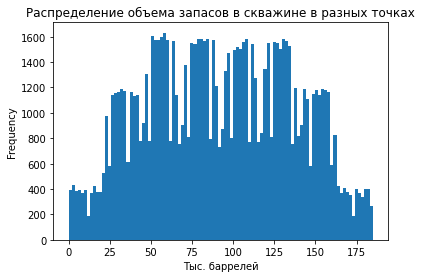

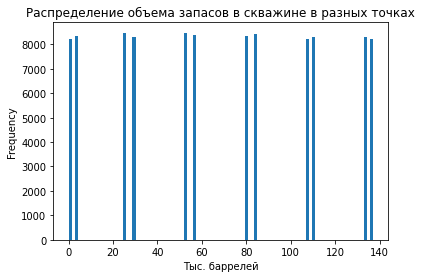

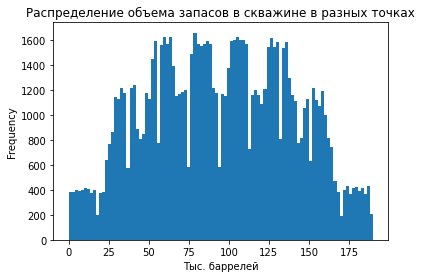

In [10]:
#посроим графики по столбцу product
ds = [data_0, data_1, data_2]
reg = ['Первый регион - data_0', 'Второй регион - data_1', 'Третий регион - data_2']
for data in ds:
    data['product'].plot(kind='hist', bins=100)
#plt.figure(figsize=(12, 8))
    plt.title('Распределение объема запасов в скважине в разных точках')
    plt.xlabel('Тыс. баррелей')
    plt.show()

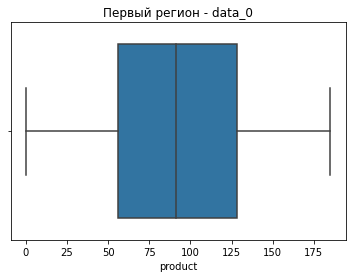

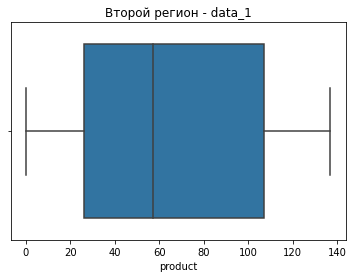

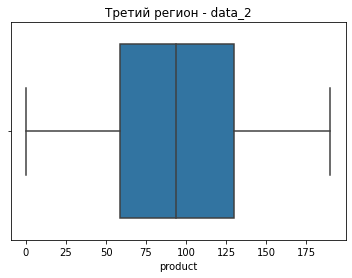

In [11]:
i = 0
for data in ds:
    sns.boxplot(x='product', data=data)
    plt.title(reg[i])
    plt.show()
    i += 1

In [12]:
display(data_0['product'].describe())
display(data_1['product'].describe())
display(data_2['product'].describe())

count    100000.000000
mean         92.001130
std          44.288439
min           0.000000
25%          56.000000
50%          91.000000
75%         128.000000
max         185.000000
Name: product, dtype: float64

count    100000.000000
mean         68.269030
std          45.716112
min           0.000000
25%          26.000000
50%          57.000000
75%         107.000000
max         137.000000
Name: product, dtype: float64

count    100000.000000
mean         94.502090
std          44.750674
min           0.000000
25%          59.000000
50%          94.000000
75%         130.000000
max         190.000000
Name: product, dtype: float64

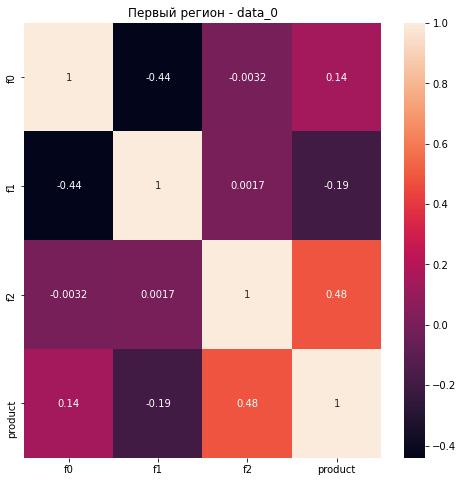

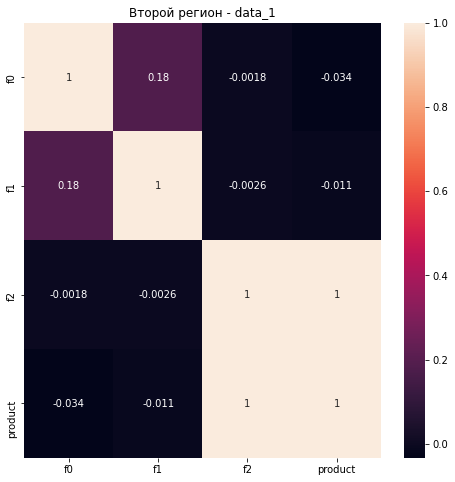

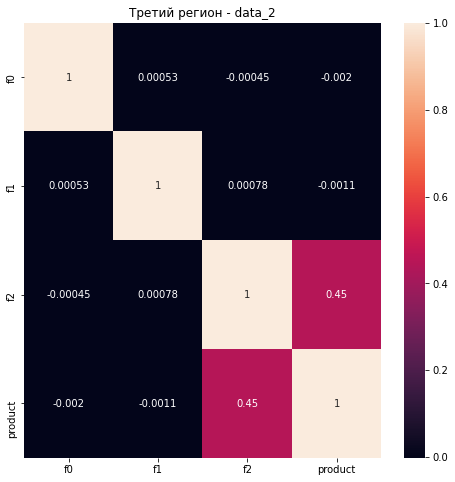

In [13]:
#посмотрим зависимость/ корреляцию данных
i = 0
for data in ds:
    plt.figure(figsize=(8, 8))
    sns.heatmap(data.corr(), annot=True)
    plt.title(reg[i])
    plt.show()
    i += 1

По графикам и показателям можно обратить внимание, что данные у первого и третьего региона почти схожи, это видно на графиках и по статистическим показателям, что нельзя сказать про второй регион. Но стандартное отклонение std по всем датасетам/ выборкам в принципе почти одинаковая.

На тепловой диаграмме видим, что признак f2 почти одинаково коррелирует с целевым признаком product в первом (0.48) и третьем (0.45) регионе, а во втором регионе целевой признак product напрямую зависит от признака f2.

Так как данные предоставлены пробы нефти из трёх разных регионов, где измеряли качество нефти и объём её запасов стоит предположить что: запасы нефти в первом и третьем регионе распределены разрозненно по всей территории, а во втором регионе запасы нефти расположенны более локализированно и в каких то конкретных местах.

## Обучение и проверка модели

In [14]:
#определим общие признаки и целевые по каждому датасету
X_0 = data_0.drop(columns=['product'])
y_0 = data_0['product']
X_1 = data_1.drop(columns=['product'])
y_1 = data_1['product']
X_2 = data_2.drop(columns=['product'])
y_2 = data_2['product']

In [15]:
#каждый датасет разобъем на обучающие и валидационные выборки

#возьмем параметр random_state как константу state
RANDOM = 12345
RANDOM_STATE = np.random.RandomState(RANDOM)

train_X_0, valid_X_0, train_y_0, valid_y_0 = train_test_split(X_0, y_0, test_size=0.25, random_state=RANDOM)
#                                                               , stratify=y_0, 

train_X_1, valid_X_1, train_y_1, valid_y_1 = train_test_split(X_1, y_1, test_size=0.25, random_state=RANDOM)
#                                                               , stratify=y_1)

train_X_2, valid_X_2, train_y_2, valid_y_2 = train_test_split(X_2, y_2, test_size=0.25, random_state=RANDOM)
#                                                               , stratify=y_2)

In [16]:
#убедимся в разделении данных на выборки
print(train_X_0.shape, valid_X_0.shape, train_y_0.shape, valid_y_0.shape)
print(train_X_1.shape, valid_X_1.shape, train_y_1.shape, valid_y_1.shape)
print(train_X_2.shape, valid_X_2.shape, train_y_2.shape, valid_y_2.shape)

(75000, 3) (25000, 3) (75000,) (25000,)
(75000, 3) (25000, 3) (75000,) (25000,)
(75000, 3) (25000, 3) (75000,) (25000,)


In [17]:
#для решения данной задачи применим модель LinearRegression
#для первого региона
model_lr_0 = LinearRegression()
model_lr_0.fit(train_X_0, train_y_0)

#для второго региона
model_lr_1 = LinearRegression()
model_lr_1.fit(train_X_1, train_y_1)

#для третьего региона
model_lr_2 = LinearRegression()
model_lr_2.fit(train_X_2, train_y_2)

LinearRegression()

In [18]:
#применим обученную модель к валидационной выборке для предсказания
predictions_0 = model_lr_0.predict(valid_X_0)
predictions_0 = pd.Series(predictions_0)
predictions_1 = model_lr_1.predict(valid_X_1)
predictions_1 = pd.Series(predictions_1)
predictions_2 = model_lr_2.predict(valid_X_2)
predictions_2 = pd.Series(predictions_2)

In [19]:
val_0 = valid_y_0.reset_index(drop=True)
val_1 = valid_y_1.reset_index(drop=True)
val_2 = valid_y_2.reset_index(drop=True)
valids = [val_0, val_1, val_2]

In [20]:
#посмотрим какие предсказанные данные выдала модель и выведем реальные данные, а также оценим модель метриков RMSE
predictions = [predictions_0, predictions_1, predictions_2]
val = [valid_y_0, valid_y_1, valid_y_2]
i = 0
for n in range(len(predictions)):
    print(f'Среднее значение product в регионе {i + 1}: {val[i].mean()} тыс. баррель')
    print(f'Среднее значение product в регионе по предсказанным значениям {i + 1}: {predictions[i].mean()} тыс. баррель')
    print(f'Среднеквадратичная ошибка RMSE показатель {i + 1}:', (mean_squared_error(val[i], predictions[i]) ** 0.5).round(2))
    i += 1
    print()

Среднее значение product в регионе 1: 91.58064 тыс. баррель
Среднее значение product в регионе по предсказанным значениям 1: 92.0933978221753 тыс. баррель
Среднеквадратичная ошибка RMSE показатель 1: 37.58

Среднее значение product в регионе 2: 68.1672 тыс. баррель
Среднее значение product в регионе по предсказанным значениям 2: 68.17320024946817 тыс. баррель
Среднеквадратичная ошибка RMSE показатель 2: 1.02

Среднее значение product в регионе 3: 94.3854 тыс. баррель
Среднее значение product в регионе по предсказанным значениям 3: 94.46742884611454 тыс. баррель
Среднеквадратичная ошибка RMSE показатель 3: 40.03



По обученным моделям можно сказать, что средний показатель предсказанных и реальных данных почти схожи. Лучше всего модель линейной регрессиии отработала на выборке data_1 (второй регион), возможно сказалось метрика f1 которая напрямую коррелирует с целевой метрикой, отмечалось ранее.

## Подготовка к расчёту прибыли

In [21]:
#зададим переменные для расчета прибыли
DEVELOPMENT_BUDGET = 100 ** 5
POINTS = 500
ML_POINTS = 200
COST_PER_BARREL = 450 * 1000
MD = 1000000000

In [22]:
#определим минимальное среднее количество продукта в месторождениях, достаточное для разработки
quantity_of_product_in_deposits = DEVELOPMENT_BUDGET / ML_POINTS / COST_PER_BARREL
print(f'Минимальное среднее количество продукта в месторождениях, достаточное для разработки: {quantity_of_product_in_deposits} тыс. баррель')

Минимальное среднее количество продукта в месторождениях, достаточное для разработки: 111.11111111111111 тыс. баррель


Для безубыточной разработки новой скважины требуется объем сырья в 111 тыс. баррелей, а из наших данных средний показатель объема сырья во всех регионах не дотягивает и до 100 тыс. баррелей. То есть при выборе случайной скважины есть риск не окупить затрачиваемый бюджет на разработку скважины. Следует рассматривать количество продукта в скважине более 111 тыс. баррелей.

In [23]:
#напишем функцию расчета прибыли
def profit_1(valid, predictions, count):
    valid = pd.Series(valid).reset_index(drop=True)
    predictions = pd.Series(predictions).reset_index(drop=True)
    pred = predictions.sort_values(ascending=False)
    valid_pred = valid[pred.index][:count]
    all_sum = valid_pred.sum() * COST_PER_BARREL
    return (all_sum - DEVELOPMENT_BUDGET) / MD

In [24]:
#применим функцию profit для определения прибыли в каждом регионе
for n in range(len(predictions)):
    print(f'Прибыль в {n + 1} регионе: {profit_1(val[n], predictions[n], 200).round(2)} млрд. рублей')

Прибыль в 1 регионе: 3.28 млрд. рублей
Прибыль в 2 регионе: 2.33 млрд. рублей
Прибыль в 3 регионе: 2.67 млрд. рублей


## Расчёт прибыли и рисков 

In [25]:
#напишем функцию Bootstrap
def bootstrap(target, predictions):
    state = np.random.RandomState(22)
    values = []
    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(500, replace=True, random_state=RANDOM_STATE)
        probs_subsample = predictions[target_subsample.index]
        result = profit_1(target_subsample, probs_subsample, 200)
        values.append(result)
    values = pd.Series(values)
    down = values.quantile(0.025)
    up = values.quantile(0.975)
    confidence_interval = (down, up)
    mean = values.mean()

    print(f'Средняя прибыль региона: {mean} млрд. рублей')
    print(f'Доверительный интервал: {confidence_interval}')
    print(f'Нижний 2,5% квантиль: {down}')
    print(f'Верхний 97,5% квантиль: {up}')
    print(f'Риски убыточности: {(values < 0).mean() * 100}%')
    return values

In [26]:
for i in range(len(valids)):
    v = bootstrap(valids[i], predictions[i])
    print('--------------------------------------')

Средняя прибыль региона: 0.35097875 млрд. рублей
Доверительный интервал: (-0.15672250000000001, 0.8636412499999999)
Нижний 2,5% квантиль: -0.15672250000000001
Верхний 97,5% квантиль: 0.8636412499999999
Риски убыточности: 9.2%
--------------------------------------
Средняя прибыль региона: 0.3942998 млрд. рублей
Доверительный интервал: (0.013197500000000011, 0.79013375)
Нижний 2,5% квантиль: 0.013197500000000011
Верхний 97,5% квантиль: 0.79013375
Риски убыточности: 2.1999999999999997%
--------------------------------------
Средняя прибыль региона: 0.34823014999999996 млрд. рублей
Доверительный интервал: (-0.15851125, 0.8889087499999998)
Нижний 2,5% квантиль: -0.15851125
Верхний 97,5% квантиль: 0.8889087499999998
Риски убыточности: 9.3%
--------------------------------------


## Общий вывод

Согласно проведенным иследованиям, выяснили что самое доходное месторождение нефти является первое месторождение показатель выручки которого составляет 3.17 млрд. рублей. Однако после проведенного моделирования было выявлено, что у данного месторождения есть риск убытка, а в нашем случаи рассматриваем только регионы с риском в 2.5%, коим является второй регион.

Самым неэффективным с точки зрения прибыльности и рисков является 3 регион, где степень риска составляет 10.3%, а средняя прибыль от данного региона 0.326 млрд. рублей.

По основным критериям выбора региона для разработки следует рассматривать второй регион, риск убытков минимален и составляет 2,4%, средняя прибыль выше по сравнению с другими месторождениями и составляет 0.385 млрд. рублей.